In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples

In [6]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [7]:
sns.set()

## Data Prep

### Read Synergy + Proballers Data

In [8]:
df1 = pd.read_csv('eurocup_offense_plus_pb.csv')
df1['league'] = 'EuroCup'
df2 = pd.read_csv('euroleague_offense_plus_pb.csv')
df2['league'] = 'EuroLeague'
df = pd.concat([df1, df2])
df.shape

(2444, 85)

In [9]:
mp_filter = df['Poss_est'] >= 300
df = df[mp_filter]
df.shape

(1658, 85)

In [10]:
df['avg_eff'] = df['Eff'] / df['GP_y']

In [11]:
def adjust_height(s):
    m, cm = s.split('m')
    return int(m) * 100 + int(cm) 

In [12]:
df['Height'] = df['Height'].apply(adjust_height)

In [13]:
df = df.reset_index(drop=True)

## Clustering

### Functions

In [14]:
def plot_pca_explained_var(x):
    ev_list = []
    c_list = list(range(2, 12))
    for c in c_list:
        pca = PCA(n_components=c)
        ev_list.append(np.sum(pca.fit(x).explained_variance_ratio_))
    
    # Plot
    plt.plot(c_list, ev_list)
    plt.hlines(0.95, 2, 11, color='red', linestyle='--')
    plt.xlabel('Number of Components (c)')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Results')

In [15]:
def plot_silhouette_score(x):
    avg_ss_list = []
    k_list = list(range(2, 16))
    for k in k_list:
        sc = SpectralClustering(n_clusters=k, 
                                affinity='nearest_neighbors', 
                                random_state=42)
        cluster_labels = sc.fit(x).labels_
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)

    # Plot
    # Plot the elbow
    plt.plot(k_list, avg_ss_list, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title('The Silhouette Score Method Showing the Optimal k')

### Define Weight Columns

In [16]:
playtypes = ['Isolation', 'P&R Ball Handler', 'Post-Up', 
             'P&R Roll Man', 'Spot Up', 'Off Screen', 
             'Hand Off', 'Cut', 
             'Offensive Rebounds', 
             'Transition']
playtype_weights = [f'{playtype}_Poss%'
                    for playtype in playtypes]

In [17]:
situations = ['Pick and Rolls Including Passes',
              'Isolations Including Passes',
              'Post-Ups Including Passes']
situation_weights = [f'{situation}_On_Court%'
                     for situation in situations]

In [18]:
shottypes = ['Catch and Shoot', 
             'At Rim',
             'Long (3 point jump shots)',
             'All Jump Shots off the Dribble'
            ]
shottype_weights = [f'{shottype}_FGA%' 
                    for shottype in shottypes]

In [19]:
weights = playtype_weights + shottype_weights + situation_weights 
weights

['Isolation_Poss%',
 'P&R Ball Handler_Poss%',
 'Post-Up_Poss%',
 'P&R Roll Man_Poss%',
 'Spot Up_Poss%',
 'Off Screen_Poss%',
 'Hand Off_Poss%',
 'Cut_Poss%',
 'Offensive Rebounds_Poss%',
 'Transition_Poss%',
 'Catch and Shoot_FGA%',
 'At Rim_FGA%',
 'Long (3 point jump shots)_FGA%',
 'All Jump Shots off the Dribble_FGA%',
 'Pick and Rolls Including Passes_On_Court%',
 'Isolations Including Passes_On_Court%',
 'Post-Ups Including Passes_On_Court%']

### Check Correlations Among Weights

Text(0.5, 1.0, 'Correlations Among Weights in EuroCup (2018-2022)')

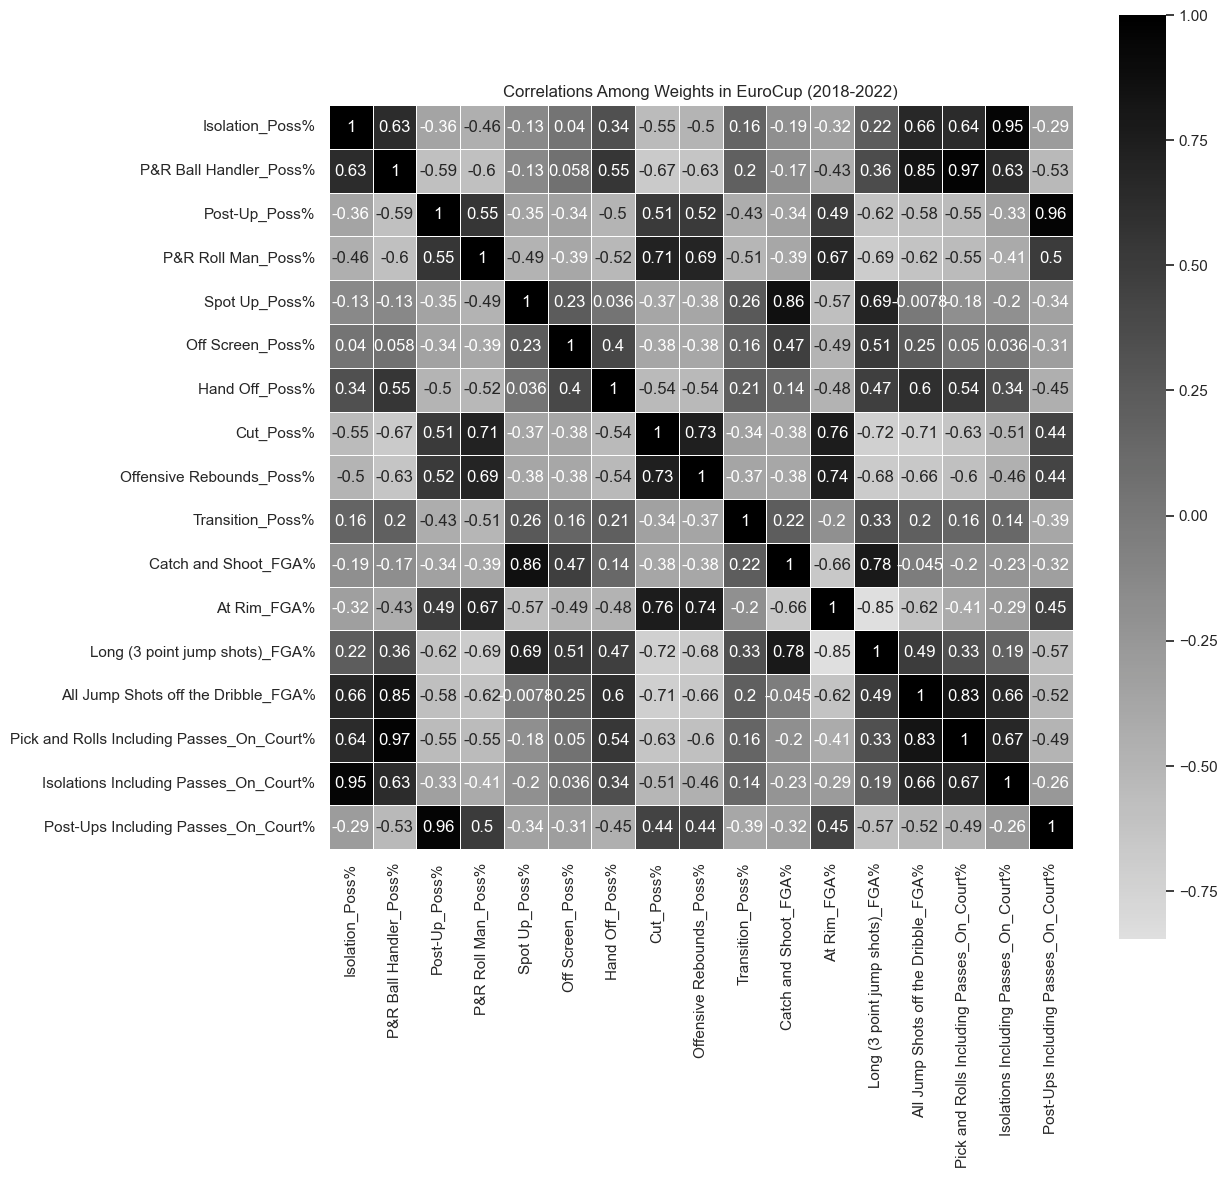

In [20]:
figsize(12, 8)
corr = df[weights].corr()
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.light_palette('black', as_cmap=True)
sns.heatmap(corr, 
            cmap=cmap, vmax=None, center=0,
            square=True, annot=True, linewidths=.5)
plt.title('Correlations Among Weights in EuroCup (2018-2022)')

### Reduce Dimensions with PCA

In [21]:
X = df[weights].copy()

Determine how many components reduce down to via PCA

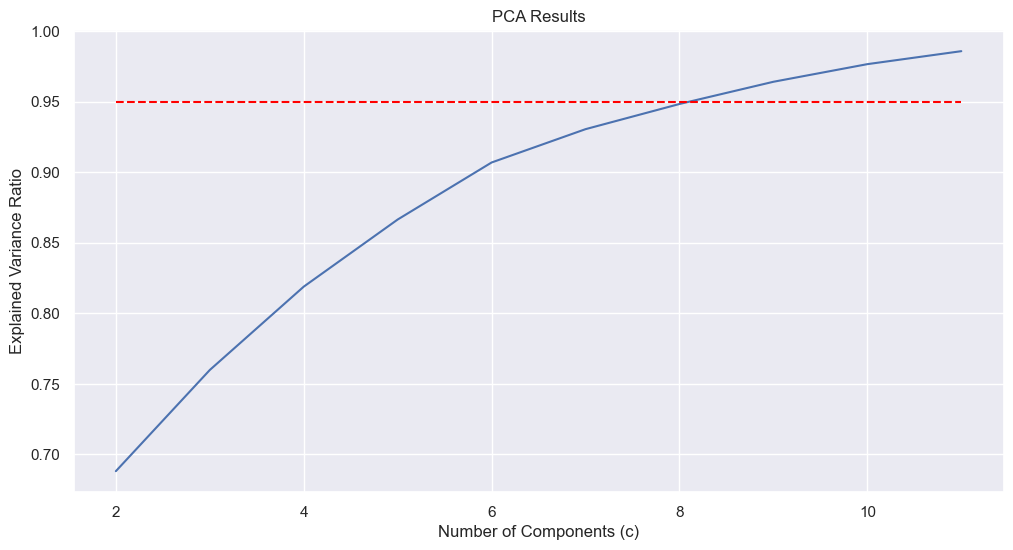

In [22]:
figsize(12, 6)
pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
# pre_pca_pipe = StandardScaler()
plot_pca_explained_var(pre_pca_pipe.fit_transform(X))

Choosse 8

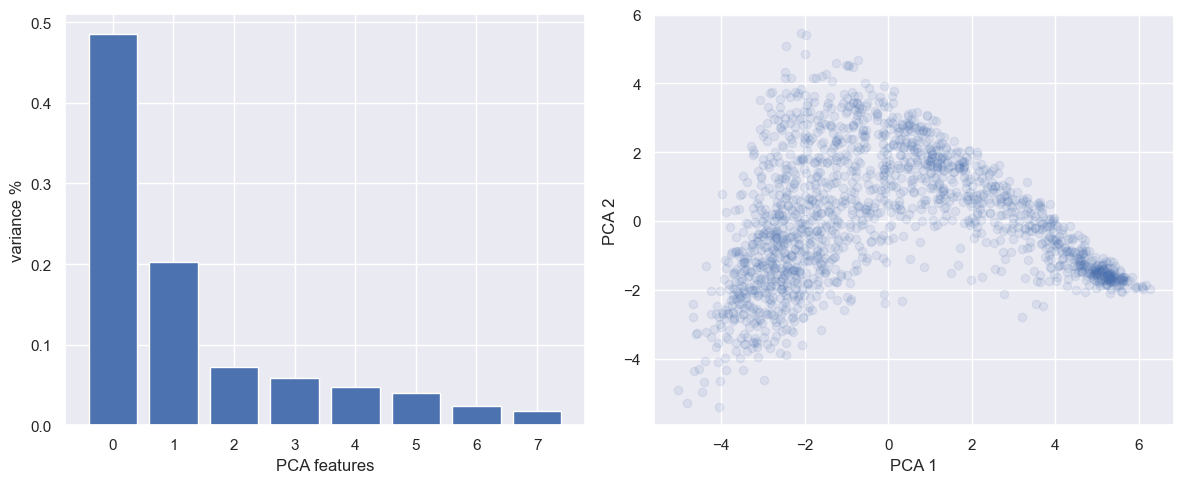

In [29]:
n_components = 8

pre_pca_pipe = make_pipeline(RobustScaler(), StandardScaler())
pca = PCA(n_components=n_components)
pca.fit(pre_pca_pipe.fit_transform(X))
pca_components = pca.transform(pre_pca_pipe.fit_transform(X))

figsize(12, 5)
plt.subplot(1, 2, 1)
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(range(pca.n_components_))

plt.subplot(1, 2, 2)
plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()

In [30]:
pre_cluster_scaler = StandardScaler()
X_transformed = pre_cluster_scaler.fit_transform(pca_components)

### Choose Optimal K

Determine # of clusters using silhouette score method

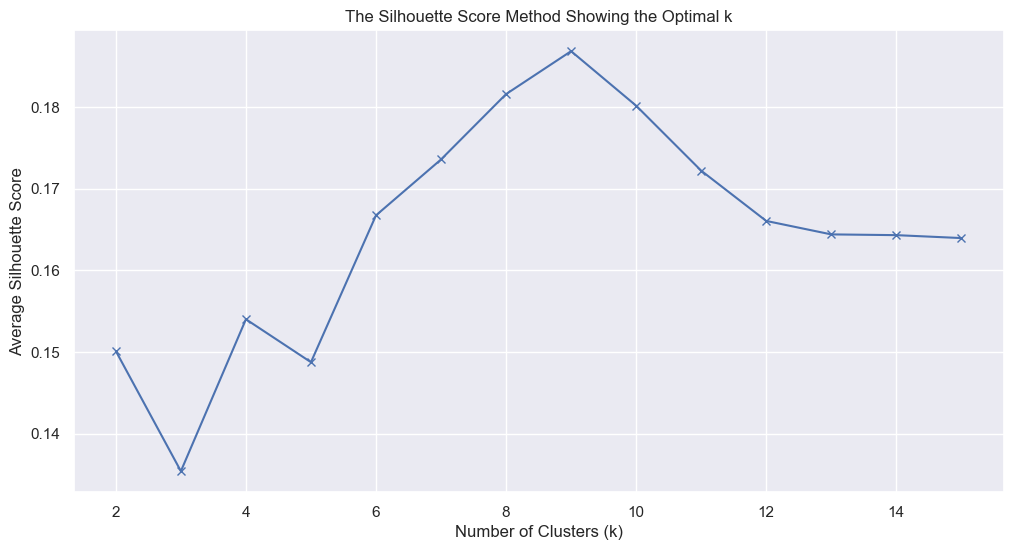

In [31]:
figsize(12, 6)
plot_silhouette_score(X_transformed)

### Clustering

In [32]:
# Choose k = 9
n_clusters = 9

sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors', 
                        random_state=42)
sc.fit(X_transformed)
df['player_cluster'] = sc.labels_
df['silhouette_coefficient'] = silhouette_samples(X_transformed, 
                                                  df['player_cluster'])
df.groupby('player_cluster').count()['Player']

player_cluster
0    121
1    409
2    284
3     98
4    117
5    128
6    283
7    124
8     94
Name: Player, dtype: int64

## Results

### Functions

In [33]:
def plot_cluster_res_2d(df, cluster_col, col1, col2, cluster_dict):
    clusters = list(set(df[cluster_col]))
    for cluster in clusters:
        cluster_cond = df[cluster_col] == cluster
        x = df[cluster_cond][col1].values * 100
        y = df[cluster_cond][col2].values * 100
        plt.scatter(x, y, 
                    label=f'Cluster {cluster}: {cluster_dict[cluster]}', 
                    alpha=0.3)
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.legend()

In [34]:
def show_cluster_res(df, cluster_col, weights=weights):
    cluster_res = df.groupby(cluster_col)[['avg_eff'] + weights]\
                    .mean().sort_values('avg_eff', ascending=False)
    cluster_cnt = Counter(df[cluster_col])
    cluster_res['avg_eff'] = cluster_res['avg_eff'].apply(lambda x: f'{x:.2f}')
    for col in cluster_res.columns:
        if '%' in col or 'Rt' in col:
            cluster_res[col] = cluster_res[col].apply(lambda x: f'{x:.2%}')
    cluster_res = cluster_res.reset_index()
    cluster_res['#'] = cluster_res[cluster_col].map(cluster_cnt)
    return cluster_res.T

### Overview

In [35]:
show_cluster_res(df, 'player_cluster')

,0,1,2,3,4,5,6,7,8
player_cluster,8,0,4,7,1,6,5,3,2
avg_eff,11.82,11.40,9.99,9.95,9.04,8.95,8.69,7.73,7.15
Isolation_Poss%,17.84%,1.82%,1.10%,0.84%,5.36%,7.34%,7.20%,4.51%,2.55%
P&R Ball Handler_Poss%,36.91%,0.28%,0.19%,0.14%,13.69%,43.92%,30.03%,15.21%,4.09%
Post-Up_Poss%,2.01%,32.93%,13.52%,13.05%,7.80%,0.79%,1.04%,1.66%,7.92%
P&R Roll Man_Poss%,0.62%,19.08%,34.66%,25.74%,3.81%,0.10%,0.35%,0.66%,6.81%
Spot Up_Poss%,18.18%,10.10%,12.62%,7.20%,30.29%,23.94%,26.15%,31.85%,46.95%
Off Screen_Poss%,5.50%,1.15%,0.81%,0.24%,5.16%,4.39%,8.53%,24.69%,4.39%
Hand Off_Poss%,3.62%,0.24%,0.13%,0.08%,2.29%,3.77%,9.63%,3.84%,1.02%
Cut_Poss%,1.81%,16.08%,19.37%,25.41%,9.06%,2.41%,3.49%,3.61%,9.11%


- Ballhandler: 8 & 6 & 5
- Big: 0 & 4 & 7
- Wing: 1 & 3 & 2

In [36]:
cluster_dict = {8: 'Ballhandler', 6: 'Ballhandler', 5: 'Ballhandler',
                0: 'Big', 4: 'Big', 7: 'Big',
                1: 'Wing', 3: 'Wing', 2: 'Wing'}

In [37]:
def color_cluster(val, cluster_dict=cluster_dict):
    if cluster_dict[val] == 'Ballhandler':
        return '#AB3B3A'
    elif cluster_dict[val] == 'Wing':
        return '#2E5C6E'
    elif cluster_dict[val] == 'Big':
        return '#F7D94C'

In [38]:
def color_cluster_pandas(val, cluster_dict=cluster_dict):
    if val in cluster_dict.keys():
        color = color_cluster(val, cluster_dict=cluster_dict)
    else:
        color = 'white'
    return f'background-color: {color}' 

In [39]:
show_cluster_res(df, 'player_cluster')\
.style.applymap(color_cluster_pandas)

,0,1,2,3,4,5,6,7,8
player_cluster,8,0,4,7,1,6,5,3,2
avg_eff,11.82,11.40,9.99,9.95,9.04,8.95,8.69,7.73,7.15
Isolation_Poss%,17.84%,1.82%,1.10%,0.84%,5.36%,7.34%,7.20%,4.51%,2.55%
P&R Ball Handler_Poss%,36.91%,0.28%,0.19%,0.14%,13.69%,43.92%,30.03%,15.21%,4.09%
Post-Up_Poss%,2.01%,32.93%,13.52%,13.05%,7.80%,0.79%,1.04%,1.66%,7.92%
P&R Roll Man_Poss%,0.62%,19.08%,34.66%,25.74%,3.81%,0.10%,0.35%,0.66%,6.81%
Spot Up_Poss%,18.18%,10.10%,12.62%,7.20%,30.29%,23.94%,26.15%,31.85%,46.95%
Off Screen_Poss%,5.50%,1.15%,0.81%,0.24%,5.16%,4.39%,8.53%,24.69%,4.39%
Hand Off_Poss%,3.62%,0.24%,0.13%,0.08%,2.29%,3.77%,9.63%,3.84%,1.02%
Cut_Poss%,1.81%,16.08%,19.37%,25.41%,9.06%,2.41%,3.49%,3.61%,9.11%


### Observations

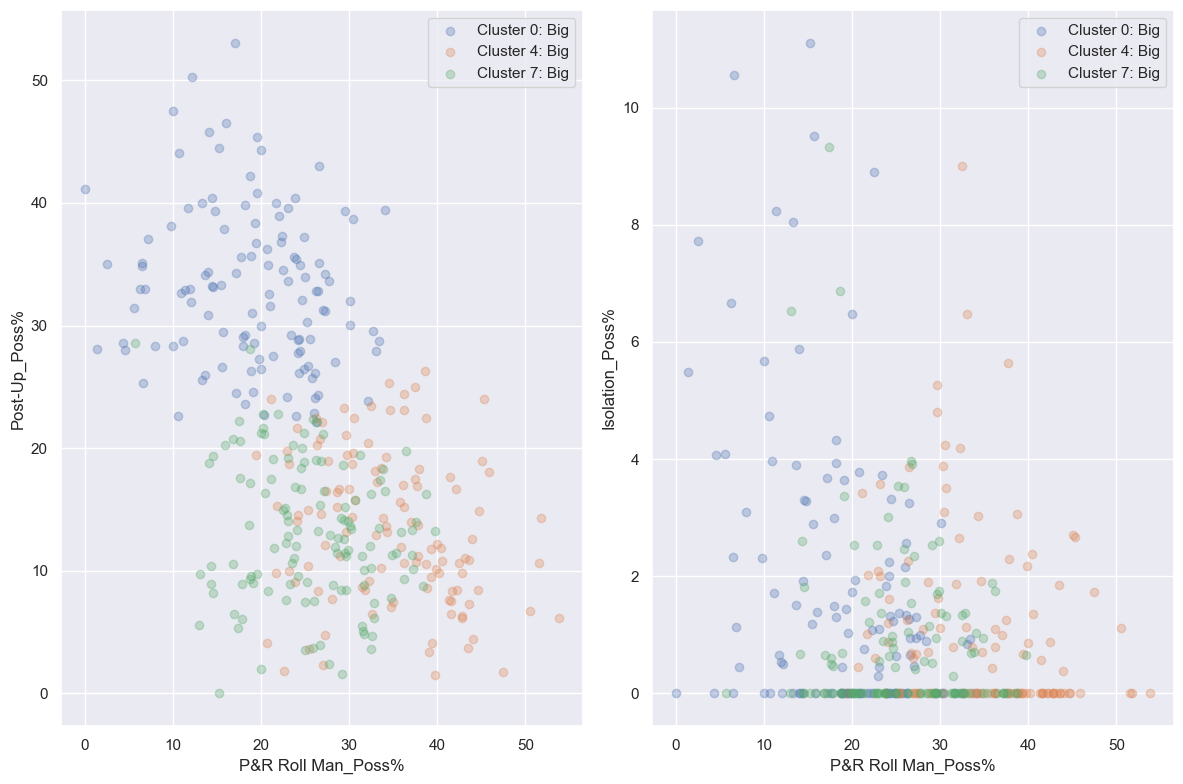

In [40]:
figsize(12, 8)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Post-Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] == 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Roll Man_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

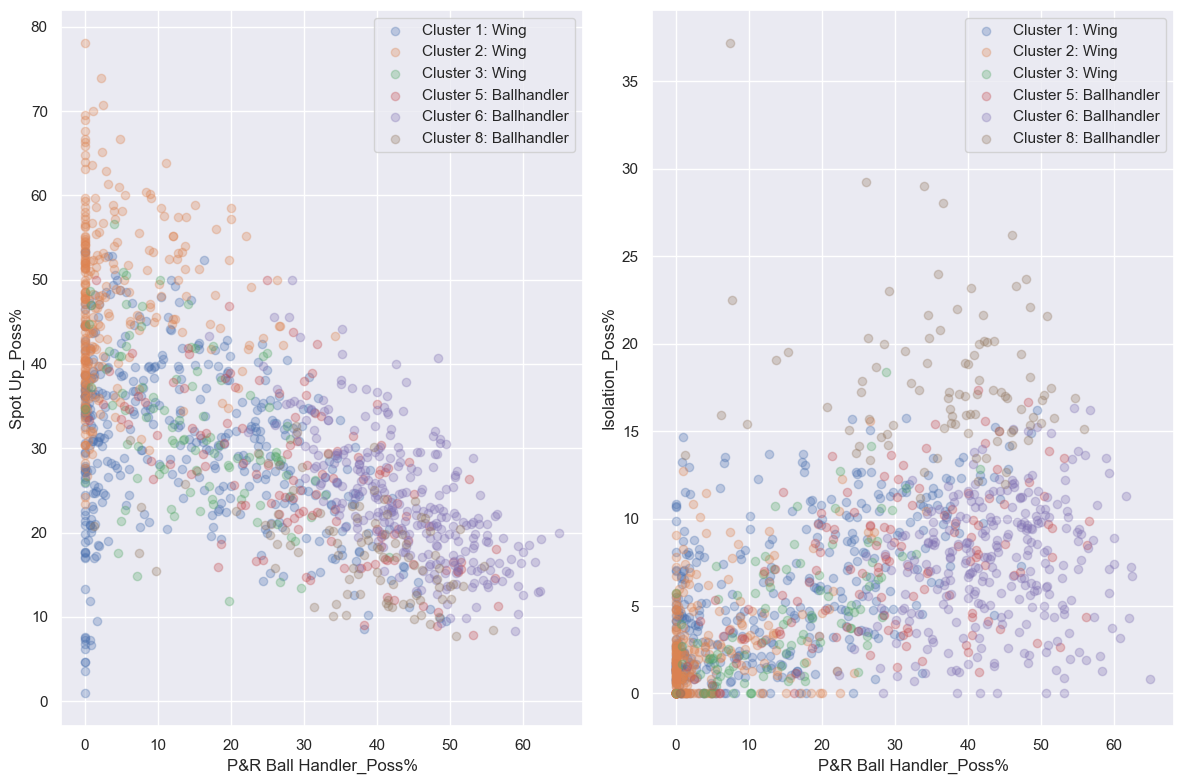

In [41]:
figsize(12, 8)
plt.subplot(1, 2, 1)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Spot Up_Poss%',
                    cluster_dict=cluster_dict)
plt.subplot(1, 2, 2)
plot_cluster_res_2d(df[df['player_cluster'].isin([cluster 
                                                  for cluster in cluster_dict.keys() 
                                                  if cluster_dict[cluster] != 'Big'])], 
                    cluster_col='player_cluster', 
                    col1='P&R Ball Handler_Poss%', 
                    col2='Isolation_Poss%',
                    cluster_dict=cluster_dict)
plt.tight_layout()

### Distributions

In [42]:
cluster_dict

{8: 'Ballhandler',
 6: 'Ballhandler',
 5: 'Ballhandler',
 0: 'Big',
 4: 'Big',
 7: 'Big',
 1: 'Wing',
 3: 'Wing',
 2: 'Wing'}

In [43]:
cluster_order = [6, 5, 8, 3, 1, 2, 7, 0, 4]

Height & EFF

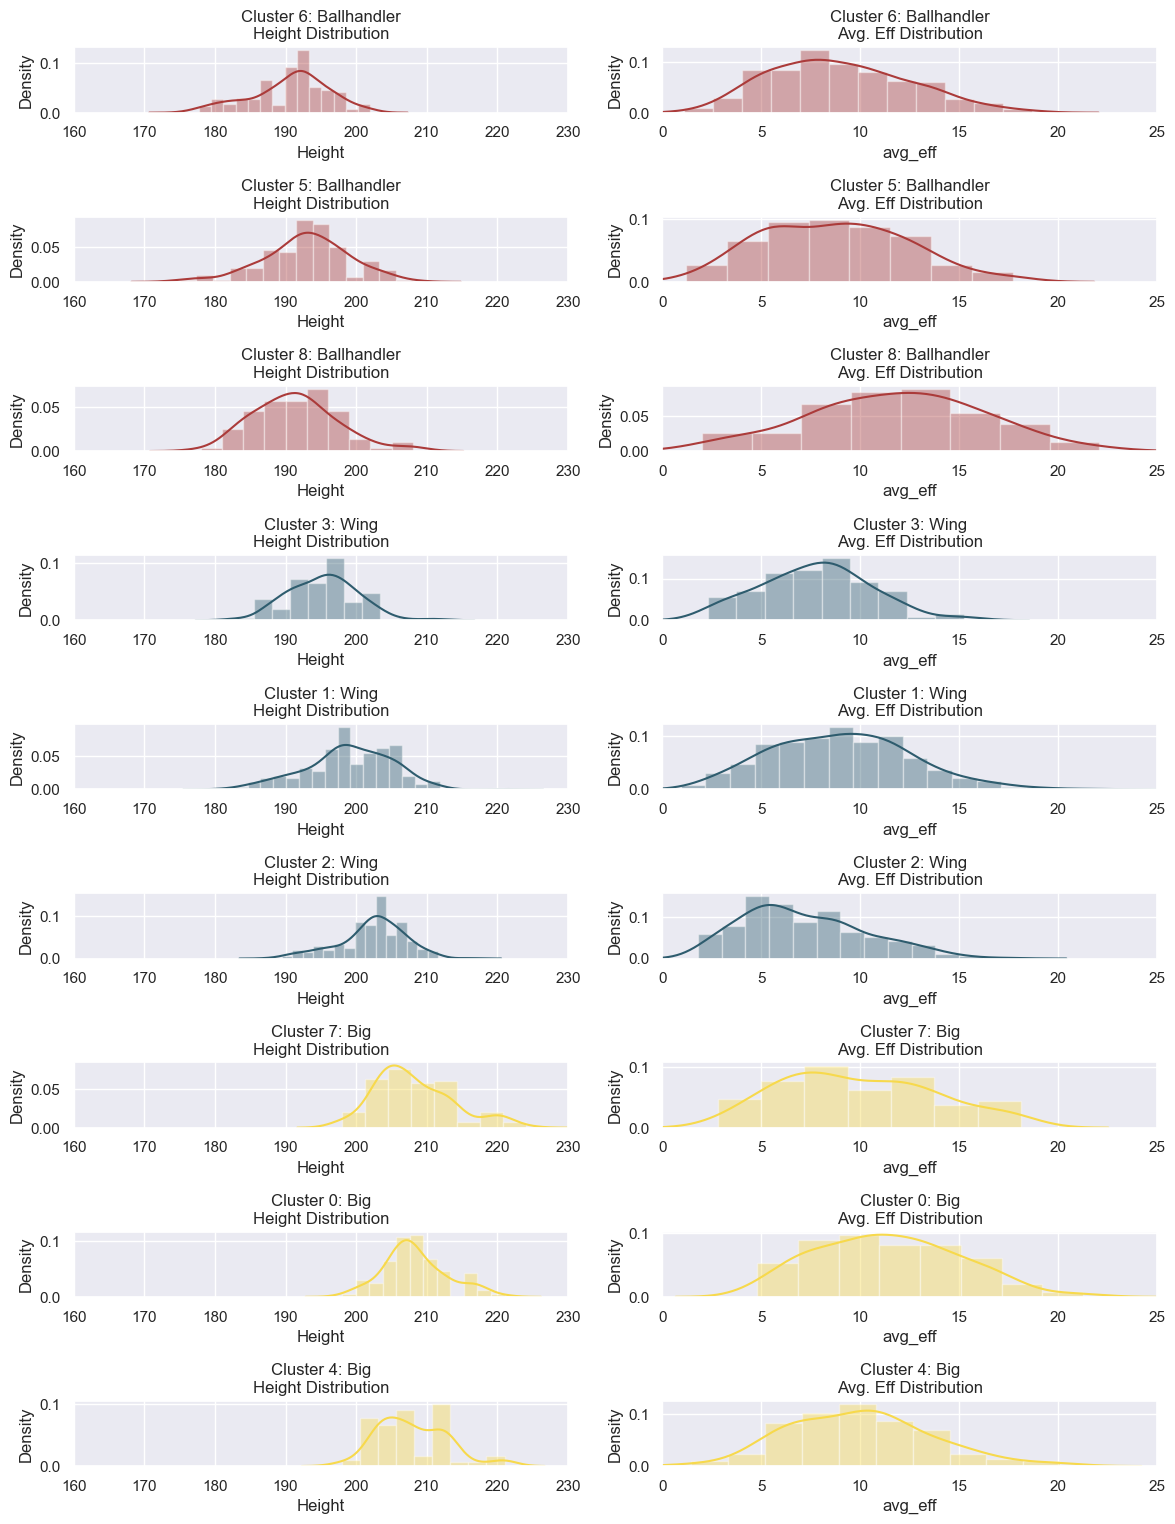

In [44]:
figsize(12, 20)
for idx, cluster in enumerate(cluster_order, 0):
    color = color_cluster(cluster)
    plt.subplot(12, 2, idx*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['Height'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nHeight Distribution')
    plt.xlim(160, 230)
    plt.subplot(12, 2, idx*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['avg_eff'],
                 color=color)
    plt.title(f'Cluster {cluster}: {cluster_dict[cluster]}\nAvg. Eff Distribution')
    plt.xlim(0, 25)
plt.tight_layout()

### Top & Bottom Players by Cluster

In [45]:
def display_cluster_players(df, cluster_col, cluster_label):
    cols = ['Player', 'Season', 'Team', 'MIN', 'Height', 'avg_eff']
    best_10 = df[df[cluster_col] == cluster_label].sort_values('avg_eff', ascending=False)\
                                                  .head(10)[cols]\
                                                  .rename(columns={'Player': 'Best 10 Players'})\
                                                  .reset_index().drop('index', axis=1)
    worst_10 = df[df[cluster_col] == cluster_label].sort_values('avg_eff')\
                                                   .head(10)[cols]\
                                                   .rename(columns={'Player': 'Worst 10 Players'})\
                                                   .reset_index().drop('index', axis=1)
    return pd.concat([best_10, worst_10], axis=1)

Ballhandlers

In [46]:
c = 8
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 94


,Best 10 Players,Season,Team,MIN,Height,avg_eff,Worst 10 Players,Season,Team,MIN,Height,avg_eff
0,Shane Larkin,2019-2020,Anadolu Efes Istanbul,739.0,182,22.080000,Filip Covic,2019-2020,Crvena Zvezda mts,176.0,178,2.000000
1,Erick Green,2020-2021,Bahcesehir Koleji Istanbul,283.0,190,20.777778,Lamar Peters,2021-2022,Cazoo Baskonia Vitoria-Gasteiz,261.0,183,2.800000
2,Errick McCollum,2021-2022,Lokomotiv Kuban,359.0,188,20.500000,Lukasz Kolenda,2021-2022,WKS Slask Wroclaw,331.0,195,2.875000
3,Alexey Shved,2018-2019,Khimki Moscow Region,442.0,198,19.000000,Kendrick Ray,2018-2019,Maccabi Playtika Tel Aviv,178.0,188,3.588235
4,Mike James,2018-2019,EA7 Emporio Armani Milan,1003.0,185,18.433333,John DiBartolomeo,2020-2021,Maccabi Playtika Tel Aviv,231.0,183,4.347826
5,Semaj Christon,2021-2022,Ratiopharm Ulm,588.0,191,18.388889,Mindaugas Girdziunas,2019-2020,BC Rytas Vilnius,219.0,188,4.437500
6,Diante Garrett,2018-2019,Tofas Bursa,327.0,195,18.100000,Curtis Jerrells,2018-2019,EA7 Emporio Armani Milan,439.0,185,4.633333
7,Alexey Shved,2020-2021,Khimki Moscow Region,741.0,198,17.956522,Allerik Freeman,2020-2021,LDLC ASVEL Lyon-Villeurbanne,365.0,191,4.833333
8,Codi Miller-McIntyre,2019-2020,Cedevita Olimpija Ljubljana,293.0,191,17.700000,Paulius Valinskas,2020-2021,Lietkabelis Panevezys,231.0,190,5.222222
9,Will Cummings,2021-2022,Metropolitans 92,573.0,186,17.650000,Cory Higgins,2021-2022,FC Barcelona,333.0,196,6.266667


In [47]:
c = 6
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 283


,Best 10 Players,Season,Team,MIN,Height,avg_eff,Worst 10 Players,Season,Team,MIN,Height,avg_eff
0,Nigel Williams-Goss,2020-2021,Lokomotiv Kuban,173.0,192,18.666667,Diego Flaccadori,2019-2020,FC Bayern München,177.0,193,1.090909
1,Isaia Cordinier,2020-2021,JSF Nanterre 92,435.0,196,18.307692,Jonas Mattisseck,2019-2020,ALBA Berlin,375.0,195,2.392857
2,Sammy Mejia,2018-2019,Tofas Bursa,285.0,198,17.900000,Matthew Strazel,2021-2022,LDLC ASVEL Lyon-Villeurbanne,459.0,182,2.433333
3,Nick Calathes,2019-2020,Panathinaikos Athens,888.0,196,16.857143,Per Günther,2021-2022,Ratiopharm Ulm,220.0,184,2.444444
4,Jaka Blazic,2020-2021,Cedevita Olimpija Ljubljana,493.0,196,16.625000,Tai Webster,2021-2022,Zalgiris Kaunas,264.0,193,2.571429
5,Justin Cobbs,2019-2020,Buducnost VOLI Podgorica,283.0,191,16.555556,Matthew Strazel,2019-2020,LDLC ASVEL Lyon-Villeurbanne,215.0,182,3.062500
6,Aaron Craft,2019-2020,Dolomiti Energia Trento,431.0,190,16.466667,Can Korkmaz,2019-2020,Galatasaray Doga Sigorta,164.0,187,3.076923
7,Yogi Ferrell,2021-2022,Cedevita Olimpija Ljubljana,414.0,180,16.200000,Leandro Bolmaro,2020-2021,FC Barcelona,287.0,200,3.241379
8,Codi Miller-McIntyre,2021-2022,MoraBanc Andorra,562.0,191,16.190476,Can Ugur Ogut,2021-2022,Turk Telekom Ankara,299.0,178,3.444444
9,Nando De Colo,2020-2021,Fenerbahce Beko Istanbul,870.0,196,15.906250,Klemen Prepelic,2018-2019,Real Madrid,181.0,192,3.500000


In [48]:
c = 5
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 128


,Best 10 Players,Season,Team,MIN,Height,avg_eff,Worst 10 Players,Season,Team,MIN,Height,avg_eff
0,Semaj Christon,2019-2020,Limoges CSP,227.0,191,17.714286,Nico Mannion,2021-2022,Virtus Segafredo Bologna,183.0,190,1.187500
1,Peyton Siva,2018-2019,ALBA Berlin,375.0,184,17.714286,Andreas Obst,2021-2022,FC Bayern München,219.0,191,1.612903
2,Milos Teodosic,2019-2020,Virtus Segafredo Bologna,388.0,195,17.133333,Ron Baker,2019-2020,CSKA Moscow,286.0,192,2.592593
3,Milos Teodosic,2020-2021,Virtus Segafredo Bologna,483.0,195,15.722222,Paul Lacombe,2020-2021,LDLC ASVEL Lyon-Villeurbanne,274.0,195,2.720000
4,Vladimir Lucic,2020-2021,FC Bayern München,951.0,204,15.419355,Matthew Strazel,2020-2021,LDLC ASVEL Lyon-Villeurbanne,250.0,182,2.950000
5,Caleb Homesley,2021-2022,Hamburg Towers,369.0,198,15.071429,Garai Zeeb,2018-2019,Fraport Skyliners Frankfurt,185.0,186,3.153846
6,Vangelis Mantzaris,2020-2021,Promitheas Patras,171.0,194,15.000000,Franz Wagner,2018-2019,ALBA Berlin,201.0,205,3.227273
7,Vincent Sanford,2019-2020,Limoges CSP,184.0,193,14.428571,Dmitry Khvostov,2019-2020,Zenit Saint Petersburg,248.0,190,3.388889
8,Marco Belinelli,2020-2021,Virtus Segafredo Bologna,201.0,194,14.400000,Malte Delow,2021-2022,ALBA Berlin,428.0,198,3.666667
9,Shavon Shields,2020-2021,EA7 Emporio Armani Milan,944.0,201,14.027778,Shelvin Mack,2019-2020,EA7 Emporio Armani Milan,184.0,193,3.727273


Bigs

In [49]:
c = 0
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 121


,Best 10 Players,Season,Team,MIN,Height,avg_eff,Worst 10 Players,Season,Team,MIN,Height,avg_eff
0,Rasid Mahalbasic,2019-2020,EWE Baskets Oldenburg,382.0,210,21.266667,Filip Barovic,2018-2019,Buducnost VOLI Podgorica,328.0,207,4.785714
1,Alan Williams,2020-2021,Lokomotiv Kuban,215.0,203,20.500000,Dragan Apic,2020-2021,Buducnost VOLI Podgorica,172.0,206,4.928571
2,Nikola Mirotic,2021-2022,FC Barcelona,928.0,208,18.236842,Ian Vougioukas,2018-2019,Panathinaikos Athens,203.0,211,5.136364
3,Nikola Milutinov,2018-2019,Olympiacos Pireaus,716.0,213,17.821429,Maik Zirbes,2019-2020,Cedevita Olimpija Ljubljana,157.0,207,5.500000
4,Vladimir Stimac,2018-2019,Turk Telekom Ankara,243.0,211,17.800000,Oguz Savas,2018-2019,Darussafaka Tekfen Istanbul,351.0,213,5.592593
5,Jalen Reynolds,2018-2019,Zenit Saint Petersburg,388.0,207,17.687500,Michael Ojo,2019-2020,Crvena Zvezda mts,244.0,216,5.818182
6,Nikola Mirotic,2020-2021,FC Barcelona,843.0,208,17.181818,Joffrey Lauvergne,2019-2020,Fenerbahce Beko Istanbul,254.0,211,6.000000
7,Mouhammadou Jaiteh,2021-2022,Virtus Segafredo Bologna,463.0,211,16.904762,Gasper Vidmar,2019-2020,Umana Reyer Venezia,184.0,210,6.200000
8,Tornike Shengelia,2019-2020,Cazoo Baskonia Vitoria-Gasteiz,842.0,206,16.892857,Ben Bentil,2020-2021,Panathinaikos Athens,481.0,206,6.354839
9,Nikola Milutinov,2019-2020,Olympiacos Pireaus,594.0,213,16.875000,Andrija Stipanovic,2019-2020,Cedevita Olimpija Ljubljana,199.0,209,6.500000


In [50]:
c = 4
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 117


,Best 10 Players,Season,Team,MIN,Height,avg_eff,Worst 10 Players,Season,Team,MIN,Height,avg_eff
0,Hassan Martin,2019-2020,Buducnost VOLI Podgorica,236.0,201,20.111111,Ilimane Diop,2020-2021,Cazoo Baskonia Vitoria-Gasteiz,168.0,211,1.444444
1,Dylan Osetkowski,2020-2021,Ratiopharm Ulm,268.0,207,19.600000,Leon Radosevic,2019-2020,FC Bayern München,201.0,208,3.052632
2,Jan Vesely,2020-2021,Fenerbahce Beko Istanbul,858.0,213,17.870968,Leon Radosevic,2020-2021,FC Bayern München,497.0,208,3.729730
3,Jan Vesely,2021-2022,Fenerbahce Beko Istanbul,625.0,213,17.363636,Ilimane Diop,2019-2020,Cazoo Baskonia Vitoria-Gasteiz,275.0,211,4.370370
4,Jordan Mickey,2020-2021,Khimki Moscow Region,799.0,203,16.464286,Jehyve Floyd,2021-2022,Fenerbahce Beko Istanbul,179.0,203,4.928571
5,Goga Bitadze,2018-2019,Buducnost VOLI Podgorica,307.0,212,16.230769,Martinas Geben,2020-2021,Zalgiris Kaunas,255.0,208,4.939394
6,Jan Vesely,2018-2019,Fenerbahce Beko Istanbul,762.0,213,16.161290,Filip Petrusev,2021-2022,Anadolu Efes Istanbul,206.0,211,5.136364
7,Bryant Dunston,2019-2020,Anadolu Efes Istanbul,228.0,203,15.555556,Nicolas Bretzel,2021-2022,Ratiopharm Ulm,184.0,212,5.250000
8,Jock Landale,2018-2019,Partizan NiS Beograd,394.0,213,15.375000,Eddy Edigin,2021-2022,Hamburg Towers,183.0,203,5.411765
9,Kenny Kadji,2020-2021,Frutti Extra Bursaspor Basketbol,213.0,210,15.222222,Leon Radosevic,2018-2019,FC Bayern München,433.0,208,5.413793


In [51]:
c = 7
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 124


,Best 10 Players,Season,Team,MIN,Height,avg_eff,Worst 10 Players,Season,Team,MIN,Height,avg_eff
0,Artsiom Parakhouski,2018-2019,BC Rytas Vilnius,186.0,211,18.125000,Kaleb Tarczewski,2021-2022,EA7 Emporio Armani Milan,318.0,213,2.800000
1,Walter Tavares,2020-2021,Real Madrid,922.0,220,18.083333,Maximilian Ladurner,2021-2022,Dolomiti Energia Trento,206.0,208,3.000000
2,Vincent Poirier,2018-2019,Cazoo Baskonia Vitoria-Gasteiz,853.0,213,17.823529,Roman Sorkin,2021-2022,Maccabi Playtika Tel Aviv,184.0,208,3.863636
3,Walter Tavares,2021-2022,Real Madrid,804.0,220,17.542857,Maximilian Ladurner,2020-2021,Dolomiti Energia Trento,192.0,208,3.875000
4,Vince Hunter,2021-2022,Metropolitans 92,502.0,203,17.500000,Joel Bolomboy,2018-2019,CSKA Moscow,249.0,205,3.964286
5,Georgios Papagiannis,2021-2022,Panathinaikos Athens,823.0,220,17.482759,Marco Voeller,2018-2019,Fraport Skyliners Frankfurt,169.0,199,4.125000
6,Arturas Gudaitis,2018-2019,EA7 Emporio Armani Milan,491.0,211,17.190476,Paul Biligha,2019-2020,EA7 Emporio Armani Milan,168.0,200,4.153846
7,Willie Reed,2020-2021,Buducnost VOLI Podgorica,378.0,211,17.000000,Mathias Lessort,2019-2020,FC Bayern München,239.0,206,4.363636
8,Nikola Milutinov,2020-2021,CSKA Moscow,461.0,213,16.600000,Alen Omic,2018-2019,EA7 Emporio Armani Milan,168.0,216,4.571429
9,Johnny Hamilton,2019-2020,Darussafaka Tekfen Istanbul,417.0,213,16.066667,Alex Tyus,2020-2021,Real Madrid,232.0,204,4.750000


Wings

In [52]:
c = 1
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 409


,Best 10 Players,Season,Team,MIN,Height,avg_eff,Worst 10 Players,Season,Team,MIN,Height,avg_eff
0,Johnathan Motley,2021-2022,Lokomotiv Kuban,239.0,206,22.111111,Arturs Kurucs,2021-2022,Cazoo Baskonia Vitoria-Gasteiz,222.0,193,0.923077
1,Nikola Mirotic,2019-2020,FC Barcelona,764.0,208,19.857143,Yiftach Ziv,2021-2022,Maccabi Playtika Tel Aviv,171.0,191,1.739130
2,Jaron Blossomgame,2021-2022,Ratiopharm Ulm,631.0,201,19.000000,Malte Delow,2020-2021,ALBA Berlin,186.0,198,2.000000
3,Kendrick Perry,2020-2021,Cedevita Olimpija Ljubljana,439.0,183,18.375000,Jeremy Pargo,2018-2019,Maccabi Playtika Tel Aviv,206.0,187,2.090909
4,Alex Hamilton,2019-2020,Maccabi ILAND.TV Rishon Lezion,323.0,192,17.800000,Omer Al,2021-2022,Frutti Extra Bursaspor Basketbol,186.0,181,2.315789
5,Darius Thompson,2021-2022,Lokomotiv Kuban,360.0,193,17.333333,Dogus Balbay,2020-2021,Anadolu Efes Istanbul,186.0,185,2.344828
6,Maik Kotsar,2021-2022,Hamburg Towers,428.0,211,17.062500,Steve Vasturia,2020-2021,Zalgiris Kaunas,214.0,196,2.368421
7,JaCorey Williams,2020-2021,Dolomiti Energia Trento,358.0,203,16.785714,Tim Schneider,2021-2022,ALBA Berlin,260.0,208,2.500000
8,Sasha Vezenkov,2021-2022,Olympiacos Pireaus,1147.0,206,16.736842,Melih Mahmutoglu,2020-2021,Fenerbahce Beko Istanbul,373.0,192,2.535714
9,Achille Polonara,2020-2021,Cazoo Baskonia Vitoria-Gasteiz,970.0,202,16.696970,Dmitrii Uzinskii,2021-2022,Unics Kazan,272.0,200,2.680000


In [53]:
c = 3
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 98


,Best 10 Players,Season,Team,MIN,Height,avg_eff,Worst 10 Players,Season,Team,MIN,Height,avg_eff
0,Sergey Karasev,2018-2019,Zenit Saint Petersburg,243.0,200,15.222222,Melih Mahmutoglu,2021-2022,Fenerbahce Beko Istanbul,243.0,192,2.304348
1,Jamar Smith,2019-2020,Unics Kazan,409.0,191,14.933333,Edwin Jackson,2019-2020,LDLC ASVEL Lyon-Villeurbanne,335.0,190,2.470588
2,Anthony Brown,2020-2021,Metropolitans 92,539.0,201,13.166667,Karolis Lukosiunas,2021-2022,Zalgiris Kaunas,234.0,197,2.500000
3,Billy Baron,2018-2019,Crvena Zvezda mts,424.0,188,12.187500,Evgeny Voronov,2019-2020,Zenit Saint Petersburg,308.0,196,2.944444
4,Michael Bramos,2019-2020,Umana Reyer Venezia,422.0,198,12.125000,Sergey Karasev,2021-2022,Zenit Saint Petersburg,256.0,200,3.000000
5,Rokas Giedraitis,2020-2021,Cazoo Baskonia Vitoria-Gasteiz,969.0,200,12.029412,Troy Daniels,2021-2022,EA7 Emporio Armani Milan,289.0,195,3.076923
6,Michael Bramos,2020-2021,Umana Reyer Venezia,201.0,198,12.000000,Fabio Mian,2018-2019,Dolomiti Energia Trento,159.0,196,3.300000
7,Nemanja Nedovic,2021-2022,Panathinaikos Athens,614.0,192,11.692308,Antoine Diot,2021-2022,LDLC ASVEL Lyon-Villeurbanne,212.0,191,3.437500
8,Thomas Klepeisz,2021-2022,Ratiopharm Ulm,477.0,189,11.578947,Rihards Lomazs,2019-2020,LDLC ASVEL Lyon-Villeurbanne,345.0,186,3.777778
9,Hugo Invernizzi,2019-2020,Limoges CSP,216.0,198,11.333333,Dairis Bertans,2020-2021,Khimki Moscow Region,333.0,192,3.850000


In [54]:
c = 2
print('# Players:', df.groupby('player_cluster').count()['Player'][c])
display_cluster_players(df, 'player_cluster', c)

# Players: 284


,Best 10 Players,Season,Team,MIN,Height,avg_eff,Worst 10 Players,Season,Team,MIN,Height,avg_eff
0,Nigel Hayes,2018-2019,Galatasaray Doga Sigorta,287.0,203,17.400000,Lefteris Bochoridis,2021-2022,Panathinaikos Athens,221.0,196,1.789474
1,Kevin Hervey,2020-2021,Lokomotiv Kuban,453.0,206,15.411765,Jerian Grant,2021-2022,EA7 Emporio Armani Milan,324.0,196,1.884615
2,Adrien Moerman,2018-2019,Anadolu Efes Istanbul,1058.0,202,15.216216,Anton Ponkrashov,2019-2020,Zenit Saint Petersburg,246.0,200,2.000000
3,Gediminas Orelik,2021-2022,Lietkabelis Panevezys,431.0,200,14.866667,Ivan Ukhov,2020-2021,CSKA Moscow,228.0,193,2.038462
4,Pierre Pelos,2020-2021,JL Bourg Basket,376.0,205,14.000000,Semen Antonov,2019-2020,CSKA Moscow,159.0,203,2.190476
5,Sasha Vezenkov,2020-2021,Olympiacos Pireaus,716.0,206,13.870968,Semen Antonov,2020-2021,CSKA Moscow,267.0,203,2.250000
6,Jonas Jerebko,2019-2020,Khimki Moscow Region,651.0,208,13.857143,Tim Schneider,2020-2021,ALBA Berlin,301.0,208,2.250000
7,David Dudzinski,2021-2022,Frutti Extra Bursaspor Basketbol,677.0,206,13.772727,Andrea Mezzanotte,2019-2020,Dolomiti Energia Trento,263.0,208,2.312500
8,Gytis Masiulis,2020-2021,Lietkabelis Panevezys,220.0,206,13.625000,Dmitrii Uzinskii,2020-2021,Unics Kazan,274.0,200,2.318182
9,Anthony Randolph,2019-2020,Real Madrid,449.0,211,13.368421,Egor Vyaltsev,2018-2019,Khimki Moscow Region,216.0,193,2.500000


### Edge Cases

In [55]:
temp = df.groupby('Player')['player_cluster'].apply(list).reset_index()
temp['player_cluster_adj'] = temp['player_cluster'].apply(lambda x: [cluster_dict[s] 
                                                                     for s in x])\
                                                   .apply(set)
temp['player_cluster'] = temp['player_cluster'].apply(set)
temp['n_cluster'] = temp['player_cluster_adj'].apply(len)
temp[temp['n_cluster'] == 3]

,Player,player_cluster,player_cluster_adj,n_cluster


In [56]:
temp[(temp['n_cluster'] == 2) & 
     (temp['player_cluster_adj'] == set(['Ballhandler', 'Big']))]

,Player,player_cluster,player_cluster_adj,n_cluster


## Visualization via TSNE

In [57]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.2.0.


Changed in version 1.2: The default value changed to "pca".  
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE

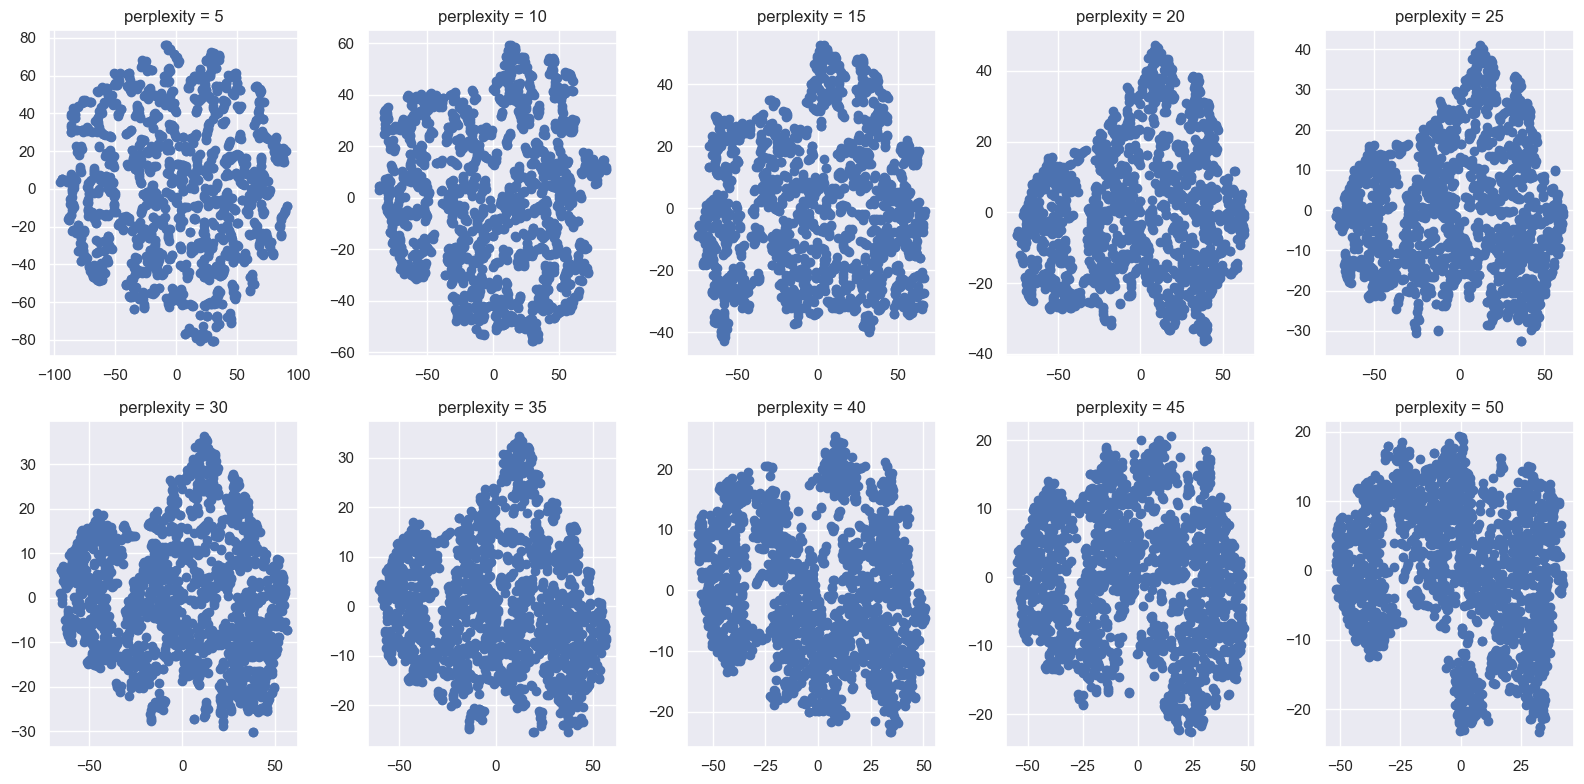

In [58]:
figsize(16, 8)
for i in list(range(1, 11)):
    plt.subplot(2, 5, i)
    perplexity = 5 * i
    tsne = TSNE(perplexity=perplexity, 
#                 early_exaggeration=4,
                init='random',
                random_state=42)
    X_tsne = tsne.fit_transform(X_transformed)
    plt.scatter(X_tsne[:,0], X_tsne[:, 1])
    plt.title(f'perplexity = {perplexity}')
plt.tight_layout()

In [59]:
perplexity = 30
tsne = TSNE(perplexity=perplexity, 
#             early_exaggeration=4,
            init='random',
            random_state=42)
X_tsne = tsne.fit_transform(X_transformed)

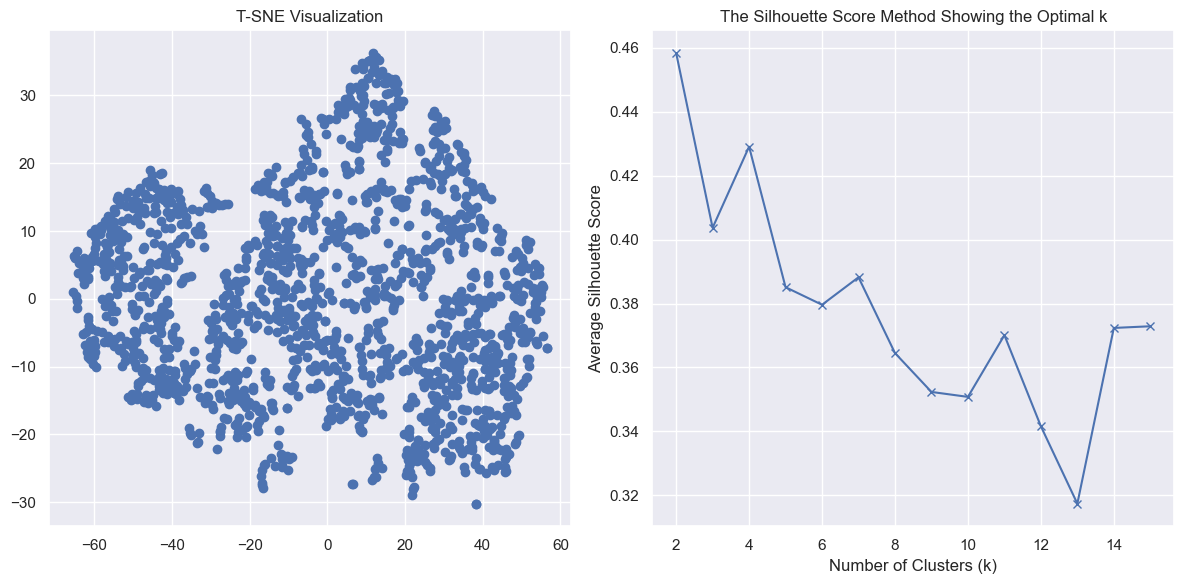

In [60]:
figsize(12, 6)
plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1])
plt.title('T-SNE Visualization')
plt.subplot(1, 2, 2)
plot_silhouette_score(X_tsne)
plt.tight_layout()

In [61]:
upper_limit = 80
lower_limit = -40
loc = 'upper left'

Text(0.5, 1.0, 'Spectral Clustering based on 8 PCA features')

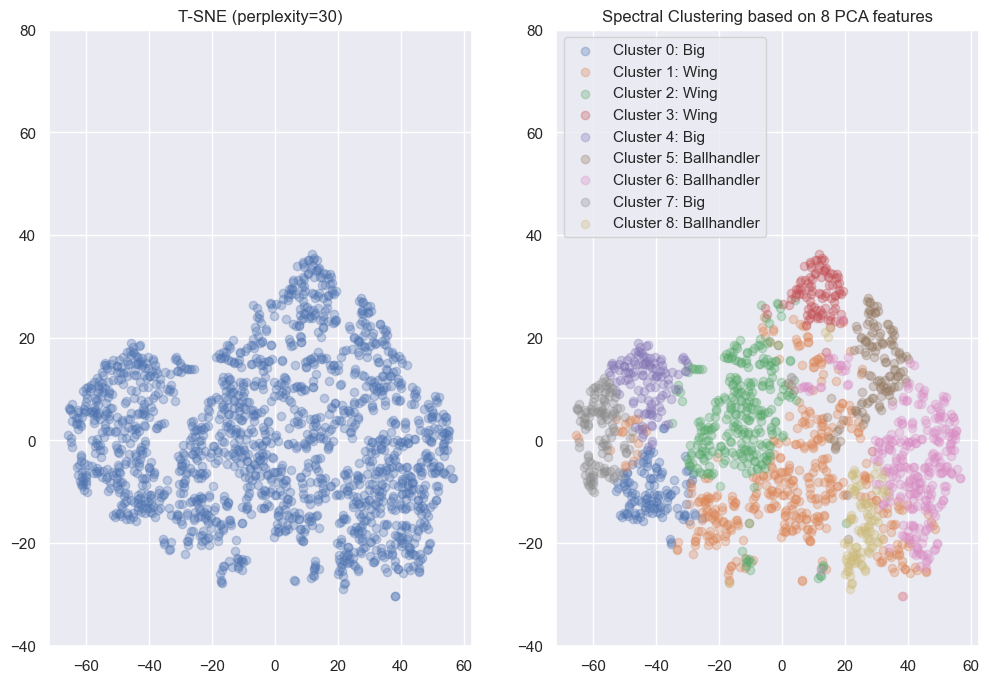

In [62]:
figsize(12, 8)

plt.subplot(1, 2, 1)
plt.scatter(X_tsne[:,0], X_tsne[:, 1], alpha=0.3)
plt.title(f'T-SNE (perplexity={perplexity})')
plt.ylim(lower_limit, upper_limit)

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')

In [69]:
df_tsne = df.copy()
n_clusters_tsne = 3

sc_tsne = SpectralClustering(n_clusters=n_clusters_tsne, 
                             affinity='nearest_neighbors', 
                             random_state=42)
sc_tsne.fit(X_tsne)
df_tsne['cluster_label_tsne'] = sc_tsne.labels_

Text(0.5, 1.0, 'Spectral Clustering based on 8 PCA features')

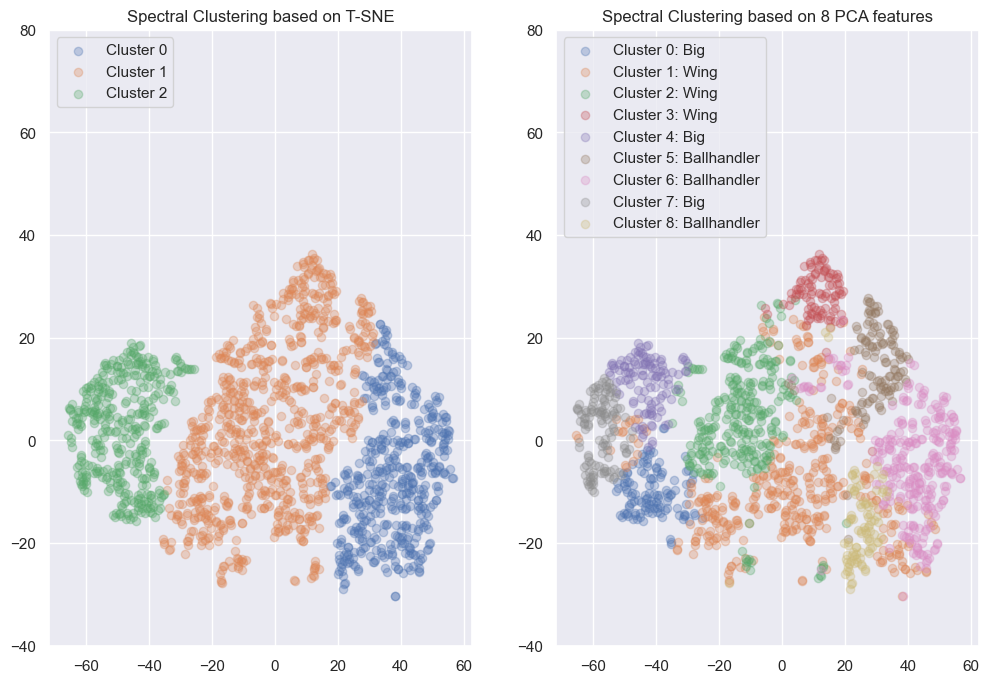

In [70]:
figsize(12, 8)

plt.subplot(1, 2, 1)
for i in range(n_clusters_tsne):
    cluster_cond = df_tsne['cluster_label_tsne'] == i
    cluster_index = df_tsne[cluster_cond].index
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title('Spectral Clustering based on T-SNE')

plt.subplot(1, 2, 2)
sc = SpectralClustering(n_clusters=n_clusters, 
                        affinity='nearest_neighbors',
                        random_state=42)
labels = sc.fit_predict(X_transformed)
for i in range(n_clusters):
    cluster_index = [j for j in range(len(labels)) if labels[j] == i]
    plt.scatter(X_tsne[cluster_index, 0], 
                X_tsne[cluster_index, 1], 
                label=f'Cluster {i}: {cluster_dict[i]}', 
                alpha=0.3)
plt.legend(loc=loc)
plt.ylim(lower_limit, upper_limit)
plt.title(f'Spectral Clustering based on {n_components} PCA features')